# TP1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 8th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [4]:
# Change here using YOUR first and last names
fn1 = "benoit-marie"
ln1 = "robaglia"
fn2 = "tahar"
ln2 = "nguira"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_robaglia_benoit-marie_and_nguira_tahar.ipynb


In [1]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

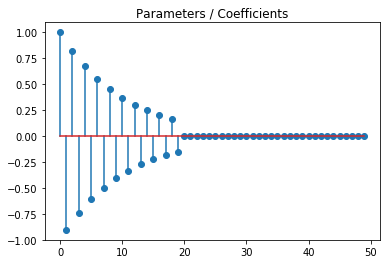

In [3]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [4]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b[:] = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Ridge penalization, where $g(x) = \frac{s}{2} \|x\|_2^2$
- Lasso penalization, where $g(x) = s \|x\|_1$

where $s \geq 0$ is a regularization parameter.

## Questions

- Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below
- Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 

In [57]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""    
    output = x.copy()
    for l in range(len(x)):
        if x[l]-t*s>0:
            output[l]=x[l]-t*s
        elif abs(x[l])<=t*s:
            output[l]=0
        else:
            output[l]=x[l]+t*s
    return output

def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    return s*np.sum(abs(x))

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x with strength t"""   
    return x/(1+s*t)
    
def ridge(x, s):
    """Value of the ridge penalization at x with strength t"""
    return 0.5*s*(np.linalg.norm(x))**2


## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

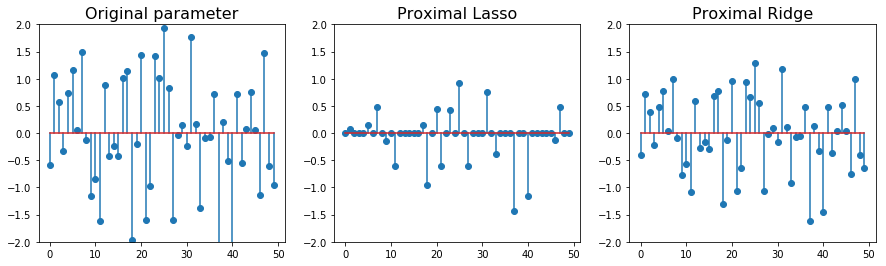

In [6]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

## Question

- Comment what you observe (1 or 2 sentences).

For the proximal lasso, all coefficients between - ts and ts are reduced to 0 by construction and that is what we see. We can also see that all other values are decreased (by ts according to the formula)

For the Proximal operator on the ridge penalization, we can see that the magnitude of the coefficients is reduced (by the factor $\frac{1}{1+ts}$ but no coefficient is set to 0

## YOUR ANSWER HERE

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below the following cases

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

**Questions**:
- Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)
- Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.
- Check that these functions are correct by numerically checking the gradient, using the function ``checkgrad`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model

In [58]:
def loss_linreg(x):
    n=len(b)
    """Least-squares loss"""
    # TODO
    return 1/(2*n) * np.linalg.norm(b-np.dot(A,x))**2

def grad_linreg(x):
    n=len(b)
    """Leas-squares gradient"""
    # TODO
    return -1/n * np.dot(A.T, b - np.dot(A,x)) 

def loss_logreg(x):
    n=len(b)
    """Logistic loss"""
    # TODO
    return (1/n)*sum(np.log(1 + np.exp(-b[i]*np.dot(A[i, :].T, x))) for i in range(n))

def grad_logreg(x):
    n=len(b)
    """Logistic gradient"""
    # TODO
    return (1/n)*sum((-b[i]*(A[i, :].T)*np.exp(-b[i]*np.dot(A[i, :].T, x)))/(1 + np.exp(-b[i]*np.dot(A[i, :].T, x))) for i in range(n))


# TO BE COMPLETED

A,b = simu_linreg(coefs)
from scipy.optimize import check_grad
print(check_grad(loss_linreg, grad_linreg,x))
print(check_grad(loss_logreg, grad_logreg,x))

1.53573886701e-06
1.16142084668e-06


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

**Questions**:

- Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function `numpy.linalg.norm` (read the documentation
  of the function)

- Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms

In [8]:
A.shape

(1000, 50)

In [59]:
from numpy.linalg import norm

def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    # TODO
    n = A.shape[0]
    return (1/n) * norm(np.dot(A.T, A))

def lip_logreg(A):
    """Lipschitz constant for logistic loss"""   
    n =A.shape[0]
    # TODO
    return (1/(4*n)) * norm(np.dot(A.T, A))
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x = prox_g(x - step*grad_f(x), s, step)
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [26]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new = prox_g(z - step*grad_f(z), s, step)
        t_new = (1/2)*(1 + np.sqrt(1 + 4*(t**2)))
        z_new = x_new + ((t-1)/t_new)*(x_new - x)
        
        x = x_new
        t = t_new
        z = z_new
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [11]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2

**Questions**

- Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using FISTA with 
  1000 iterations.
- Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

### Question 1

In [12]:
#Simulation for linear regression
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

#Applying Fista Algorithm
x_f, obj_f, err_f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =1000)

#Minimum and minimizer :
minimizer = x_f
minimum = obj_f[-1]

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.35e+00 | 9.61e-01
      10 | 6.02e-01 | 4.14e-01
      20 | 4.86e-01 | 1.21e-01
      30 | 4.85e-01 | 1.10e-01
      40 | 4.84e-01 | 1.27e-01
      50 | 4.84e-01 | 1.22e-01
      60 | 4.84e-01 | 1.15e-01
      70 | 4.83e-01 | 1.18e-01
      80 | 4.83e-01 | 1.20e-01
      90 | 4.83e-01 | 1.18e-01
     100 | 4.83e-01 | 1.17e-01
     110 | 4.83e-01 | 1.18e-01
     120 | 4.83e-01 | 1.18e-01
     130 | 4.83e-01 | 1.18e-01
     140 | 4.83e-01 | 1.18e-01
     150 | 4.83e-01 | 1.18e-01
     160 | 4.83e-01 | 1.18e-01
     170 | 4.83e-01 | 1.18e-01
     180 | 4.83e-01 | 1.18e-01
     190 | 4.83e-01 | 1.18e-01
     200 | 4.83e-01 | 1.18e-01
     210 | 4.83e-01 | 1.18e-01
     220 | 4.83e-01 | 1.18e-01
     230 | 4.83e-01 | 1.18e-01
     240 | 4.83e-01 | 1.18e-01
     250 | 4.83e-01 | 1.18e-01
     260 | 4.83e-01 | 1.18e-01
     270 | 4.83e-01 | 1.18e-01
     280 | 4.83e-01 | 1.18e-01
     290 | 4.83e-01 | 1.18e-01
     300 | 4.8

The minimizer is the last value x and the minimum is the last value of the "objectives" given by fista.

In [13]:
print(minimizer, minimum)

[ 0.96 -0.88  0.74 -0.71  0.67 -0.6   0.49 -0.44  0.4  -0.37  0.42 -0.36
  0.29 -0.31  0.26 -0.25  0.19 -0.22  0.14 -0.11 -0.02  0.    0.03  0.01
  0.02  0.01 -0.07  0.02  0.07 -0.02 -0.02 -0.01 -0.05 -0.03 -0.03 -0.01
  0.08  0.05 -0.07 -0.08  0.02 -0.02  0.02 -0.03  0.06 -0.05  0.    0.01
  0.    0.02] 0.483402812262


### Question 2

The distance with the minimizer is given by the error. We chose to let it normalized by the norm of "coefs".

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.01e+01 | 3.00e+00
      10 | 3.59e+00 | 1.68e+00
      20 | 1.70e+00 | 1.12e+00
      30 | 1.05e+00 | 7.75e-01
      40 | 7.63e-01 | 5.47e-01
      50 | 6.32e-01 | 3.93e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.01e+01 | 3.00e+00
      10 | 1.31e+00 | 9.35e-01
      20 | 5.27e-01 | 1.71e-01
      30 | 5.16e-01 | 1.89e-01
      40 | 5.04e-01 | 1.10e-01
      50 | 5.02e-01 | 1.01e-01


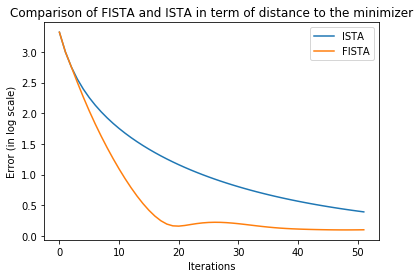

In [33]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)

x = randn(50)
i = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)
f = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)

plt.plot(i[2],label = "ISTA")
plt.plot(f[2],label = "FISTA")
ax.set_yscale('log')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error (in log scale)")
plt.title("Comparison of FISTA and ISTA in term of distance to the minimizer")
plt.show()



We can see as expected that the FISTA algorithm converges faster in term of distance to the minimizer.

#### In terms of distance to the minimum :

We want to compare the theorical minimum to the empirical ones. The latters are found in the second output of the optimization algorithms.

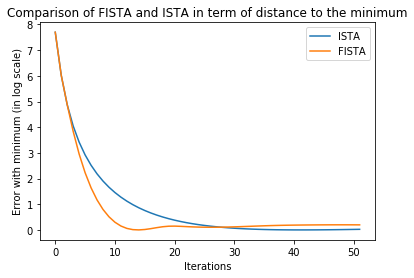

In [52]:
#Creation of the theoretical minimum.
obj_theorical = loss_linreg(coefs)+ridge(coefs,s)

#Creation of the error
error_mini_ista = [(i[2][j] - obj_theorical)**2 for j in range(len(i[2]))]
error_mini_fista = [(f[2][j] - obj_theorical)**2 for j in range(len(f[2]))]

#Creation of the figure

plt.plot(error_mini_ista, label = "ISTA")
plt.plot(error_mini_fista, label = "FISTA")
ax.set_yscale('log')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error with minimum (in log scale)")
plt.title("Comparison of FISTA and ISTA in term of distance to the minimum")
plt.show()

We have the same conclusions than before : FISTA algorithm is faster the ISTA

**Questions**

- In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain

#### Question 1 : influence of the correlation of the features on the performance of the optimization algorithms

To answer to this question, we first simulate data with different correlation. We chose : 0.2, 0.4, 0.6, 0.8. Then we will study the performance of the optimization algorithms

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.15e+00 | 9.23e-01
      10 | 4.97e-01 | 1.35e-01
      20 | 4.77e-01 | 1.05e-01
      30 | 4.74e-01 | 8.26e-02
      40 | 4.73e-01 | 8.44e-02
      50 | 4.73e-01 | 8.39e-02
      60 | 4.73e-01 | 8.32e-02
      70 | 4.73e-01 | 8.39e-02
      80 | 4.73e-01 | 8.35e-02
      90 | 4.73e-01 | 8.36e-02
     100 | 4.73e-01 | 8.36e-02
     110 | 4.73e-01 | 8.35e-02
     120 | 4.73e-01 | 8.36e-02
     130 | 4.73e-01 | 8.36e-02
     140 | 4.73e-01 | 8.36e-02
     150 | 4.73e-01 | 8.36e-02
     160 | 4.73e-01 | 8.36e-02
     170 | 4.73e-01 | 8.36e-02
     180 | 4.73e-01 | 8.36e-02
     190 | 4.73e-01 | 8.36e-02
     200 | 4.73e-01 | 8.36e-02
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.62e+00 | 9.50e-01
      10 | 5.97e-01 | 3.17e-01
      20 | 5.23e-01 | 1.21e-01
      30 | 5.19e-01 | 1.27e-01
      40 | 5.19e-01 | 1.25e-01
      50 | 5.18e-01 | 1.20e-01
      60 | 5.18e-01 | 1.22e-01
      70 | 5.18e-01 

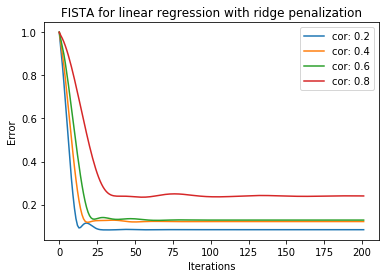

In [14]:
#Performance of fista algorithm on linear regression
#We store the Lipschitz constants also
lip_linear_constant = []
A, b = simu_linreg(coefs, n_samples=1000, corr=0.2)
lip_linear_constant.append(lip_linreg(A))
X2 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=1000, corr=0.4)
lip_linear_constant.append(lip_linreg(A))
X4 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=1000, corr=0.6)
lip_linear_constant.append(lip_linreg(A))
X6 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=1000, corr=0.8)
lip_linear_constant.append(lip_linreg(A))
X8 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

x = np.arange(len(X2[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, X2[2], label = 'cor: 0.2')
plt.plot(x, X4[2], label = 'cor: 0.4')
plt.plot(x, X6[2], label = 'cor: 0.6')
plt.plot(x, X8[2], label = 'cor: 0.8')
plt.xlabel('Iterations')
plt.ylabel('Error')


plt.title('FISTA for linear regression with ridge penalization')
plt.legend()
plt.show()

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 6.85e-01 | 9.88e-01
      10 | 5.66e-01 | 7.79e-01
      20 | 4.84e-01 | 5.11e-01
      30 | 4.58e-01 | 3.30e-01
      40 | 4.53e-01 | 2.77e-01
      50 | 4.54e-01 | 2.82e-01
      60 | 4.54e-01 | 2.86e-01
      70 | 4.54e-01 | 2.81e-01
      80 | 4.53e-01 | 2.78e-01
      90 | 4.53e-01 | 2.80e-01
     100 | 4.53e-01 | 2.81e-01
     110 | 4.53e-01 | 2.79e-01
     120 | 4.53e-01 | 2.78e-01
     130 | 4.53e-01 | 2.78e-01
     140 | 4.53e-01 | 2.78e-01
     150 | 4.53e-01 | 2.78e-01
     160 | 4.53e-01 | 2.78e-01
     170 | 4.53e-01 | 2.78e-01
     180 | 4.53e-01 | 2.78e-01
     190 | 4.53e-01 | 2.78e-01
     200 | 4.53e-01 | 2.78e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 6.88e-01 | 9.92e-01
      10 | 6.16e-01 | 8.33e-01
      20 | 5.54e-01 | 6.00e-01
      30 | 5.26e-01 | 4.08e-01
      40 | 5.19e-01 | 3.14e-01
      50 | 5.19e-01 | 2.97e-01
      60 | 5.20e-01 | 2.98e-01
      70 | 5.19e-01 

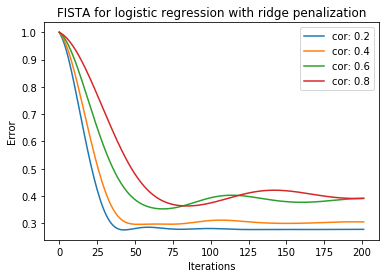

In [15]:
#Performance of fista algorithm on logistic regression with storage of the lipschitz constants
lip_logistic_constant = []
A, b = simu_logreg(coefs, n_samples=1000, corr=0.2)
lip_logistic_constant.append(lip_logreg(A))
X2 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.4)
lip_logistic_constant.append(lip_logreg(A))
X4 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.6)
lip_logistic_constant.append(lip_logreg(A))
X6 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.8)
lip_logistic_constant.append(lip_logreg(A))
X8 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

x = np.arange(len(X2[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, X2[2], label = 'cor: 0.2')
plt.plot(x, X4[2], label = 'cor: 0.4')
plt.plot(x, X6[2], label = 'cor: 0.6')
plt.plot(x, X8[2], label = 'cor: 0.8')
plt.xlabel('Iterations')
plt.ylabel('Error')


plt.title('FISTA for logistic regression with ridge penalization')
plt.legend()
plt.show()

We observe that for both regressions the higher the correlation coefficient is, the slower the FISTA algorithm is. Besides, it looks like the error rate converges to a higher level when the correlation is high.

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.13e+00 | 9.27e-01
      10 | 8.75e-01 | 4.64e-01
      20 | 6.21e-01 | 2.55e-01
      30 | 5.57e-01 | 1.56e-01
      40 | 5.39e-01 | 1.12e-01
      50 | 5.34e-01 | 9.49e-02
      60 | 5.33e-01 | 8.85e-02
      70 | 5.32e-01 | 8.62e-02
      80 | 5.32e-01 | 8.54e-02
      90 | 5.32e-01 | 8.50e-02
     100 | 5.32e-01 | 8.49e-02
     110 | 5.32e-01 | 8.48e-02
     120 | 5.32e-01 | 8.47e-02
     130 | 5.32e-01 | 8.47e-02
     140 | 5.32e-01 | 8.47e-02
     150 | 5.32e-01 | 8.47e-02
     160 | 5.32e-01 | 8.47e-02
     170 | 5.32e-01 | 8.47e-02
     180 | 5.32e-01 | 8.47e-02
     190 | 5.32e-01 | 8.47e-02
     200 | 5.32e-01 | 8.47e-02
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.66e+00 | 9.48e-01
      10 | 8.85e-01 | 5.87e-01
      20 | 6.52e-01 | 3.85e-01
      30 | 5.70e-01 | 2.67e-01
      40 | 5.38e-01 | 1.99e-01
      50 | 5.26e-01 | 1.60e-01
      60 | 5.22e-01 | 1.39e-01
      70 | 5.20e-01 | 

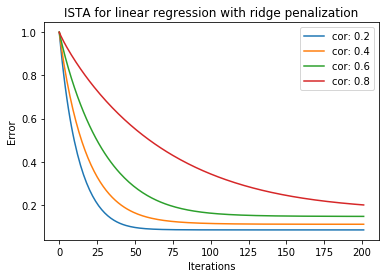

In [16]:
#Performance of ista algorithm on linear regression
A, b = simu_linreg(coefs, n_samples=1000, corr=0.2)
X2 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=1000, corr=0.4)
X4 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=1000, corr=0.6)
X6 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=1000, corr=0.8)
X8 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

x = np.arange(len(X2[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, X2[2], label = 'cor: 0.2')
plt.plot(x, X4[2], label = 'cor: 0.4')
plt.plot(x, X6[2], label = 'cor: 0.6')
plt.plot(x, X8[2], label = 'cor: 0.8')
plt.xlabel('Iterations')
plt.ylabel('Error')


plt.title('ISTA for linear regression with ridge penalization')
plt.legend()
plt.show()

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 6.85e-01 | 9.88e-01
      10 | 6.21e-01 | 8.85e-01
      20 | 5.80e-01 | 8.02e-01
      30 | 5.52e-01 | 7.35e-01
      40 | 5.33e-01 | 6.79e-01
      50 | 5.18e-01 | 6.31e-01
      60 | 5.08e-01 | 5.91e-01
      70 | 5.00e-01 | 5.56e-01
      80 | 4.93e-01 | 5.26e-01
      90 | 4.88e-01 | 4.99e-01
     100 | 4.84e-01 | 4.76e-01
     110 | 4.81e-01 | 4.56e-01
     120 | 4.79e-01 | 4.38e-01
     130 | 4.76e-01 | 4.21e-01
     140 | 4.75e-01 | 4.07e-01
     150 | 4.73e-01 | 3.94e-01
     160 | 4.72e-01 | 3.83e-01
     170 | 4.71e-01 | 3.73e-01
     180 | 4.70e-01 | 3.64e-01
     190 | 4.69e-01 | 3.56e-01
     200 | 4.69e-01 | 3.49e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 6.88e-01 | 9.91e-01
      10 | 6.44e-01 | 9.10e-01
      20 | 6.14e-01 | 8.41e-01
      30 | 5.92e-01 | 7.82e-01
      40 | 5.76e-01 | 7.30e-01
      50 | 5.63e-01 | 6.84e-01
      60 | 5.52e-01 | 6.43e-01
      70 | 5.44e-01 | 

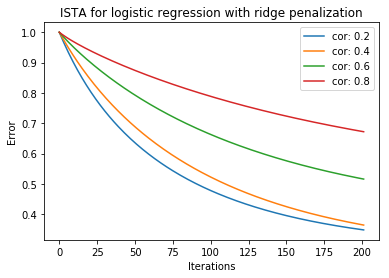

In [17]:
#Performance of ista algorithm on logistic regression
A, b = simu_logreg(coefs, n_samples=1000, corr=0.2)
X2 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.4)
X4 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.6)
X6 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.8)
X8 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

x = np.arange(len(X2[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, X2[2], label = 'cor: 0.2')
plt.plot(x, X4[2], label = 'cor: 0.4')
plt.plot(x, X6[2], label = 'cor: 0.6')
plt.plot(x, X8[2], label = 'cor: 0.8')
plt.xlabel('Iterations')
plt.ylabel('Error')


plt.title('ISTA for logistic regression with ridge penalization')
plt.legend()
plt.show()

We have the same conclusions with ISTA algorithm : when the correlation is higher, the algorithms' convergence is slower. 

##### Explanation

In [18]:
#Lipschitz constants for linear regression

for i,l in enumerate(lip_linear_constant):
    print("correlation" +" : ", i*0.2 , "constant"+" : ", l)

correlation :  0.0 constant :  7.51914219463
correlation :  0.2 constant :  8.43428604332
correlation :  0.4 constant :  10.3147443405
correlation :  0.6000000000000001 constant :  14.8760701717


In [19]:
#Lipschitz constants for logistic regression

for i,l in enumerate(lip_logistic_constant):
    print("correlation" +" : ", i*0.2 , "constant"+" : ", l)

correlation :  0.0 constant :  1.91410944717
correlation :  0.2 constant :  2.10669971915
correlation :  0.4 constant :  2.55659103243
correlation :  0.6000000000000001 constant :  3.51739629401


We can see that the lischitz constant increases with correlation. Since, according to Beck Teboulle and Nesterov theorem, we know that the error is upper-bounded linearly by L. Therefore the convergence can be slower when the correlation is higher.

### Question 2 : influence of the level of ridge penalization on the performance of the optimization algorithms. 

In this question we will set different penalization : 0, 0.2, 0.6

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.16e+01 | 2.82e+00
      10 | 1.12e+00 | 7.79e-01
      20 | 5.38e-01 | 1.88e-01
      30 | 5.24e-01 | 1.55e-01
      40 | 5.18e-01 | 1.13e-01
      50 | 5.16e-01 | 1.19e-01
      60 | 5.16e-01 | 1.16e-01
      70 | 5.15e-01 | 1.10e-01
      80 | 5.15e-01 | 1.13e-01
      90 | 5.15e-01 | 1.13e-01
     100 | 5.15e-01 | 1.12e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.46e+01 | 2.77e+00
      10 | 1.06e+00 | 5.99e-01
      20 | 8.82e-01 | 3.81e-01
      30 | 8.55e-01 | 4.00e-01
      40 | 8.53e-01 | 3.93e-01
      50 | 8.53e-01 | 3.87e-01
      60 | 8.52e-01 | 3.93e-01
      70 | 8.52e-01 | 3.90e-01
      80 | 8.52e-01 | 3.90e-01
      90 | 8.52e-01 | 3.91e-01
     100 | 8.52e-01 | 3.90e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.97e+01 | 2.67e+00
      10 | 1.14e+00 | 6.49e-01
      20 | 1.11e+00 | 6.40e-01
      30 | 1.11e+00 | 6.41e-01
      40 | 1.11e+00 | 6.40

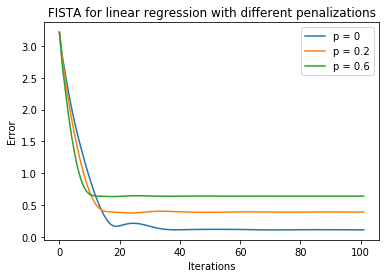

In [20]:
#Impact of the penalization for FISTA for linear regression
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)

x = randn(50)
F0 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =100)
F2 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.2, n_iter =100)
F6 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.6, n_iter =100)

x = np.arange(len(F0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, F0[2], label = 'p = 0')
plt.plot(x, F2[2], label = 'p = 0.2')
plt.plot(x, F6[2], label = 'p = 0.6')
plt.title('FISTA for linear regression with different penalizations')
plt.xlabel('Iterations')
plt.ylabel('Error')

plt.legend()
plt.show()

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.61e+00 | 2.96e+00
      10 | 2.00e+00 | 2.57e+00
      20 | 1.17e+00 | 1.91e+00
      30 | 7.34e-01 | 1.27e+00
      40 | 5.60e-01 | 8.12e-01
      50 | 5.09e-01 | 6.37e-01
      60 | 5.03e-01 | 6.45e-01
      70 | 5.04e-01 | 6.43e-01
      80 | 4.98e-01 | 5.73e-01
      90 | 4.92e-01 | 4.76e-01
     100 | 4.90e-01 | 4.03e-01
     110 | 4.90e-01 | 3.71e-01
     120 | 4.90e-01 | 3.59e-01
     130 | 4.89e-01 | 3.54e-01
     140 | 4.89e-01 | 3.54e-01
     150 | 4.88e-01 | 3.59e-01
     160 | 4.88e-01 | 3.72e-01
     170 | 4.88e-01 | 3.88e-01
     180 | 4.88e-01 | 4.02e-01
     190 | 4.88e-01 | 4.09e-01
     200 | 4.88e-01 | 4.08e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 6.90e+00 | 2.90e+00
      10 | 2.38e+00 | 1.59e+00
      20 | 6.65e-01 | 7.44e-01
      30 | 6.71e-01 | 8.12e-01
      40 | 6.34e-01 | 7.71e-01
      50 | 6.35e-01 | 7.58e-01
      60 | 6.31e-01 | 7.64e-01
      70 | 6.31e-01 

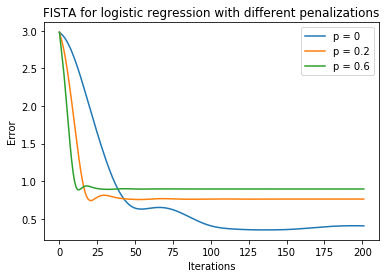

In [21]:
#Impact of the penalization for FISTA for logistic regression

A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)

x = randn(50)
Z0 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0, n_iter =200)
Z1 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.2, n_iter =200)
Z2 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.6, n_iter =200)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], label = 'p = 0')
plt.plot(x, Z1[2], label = 'p = 0.2')
plt.plot(x, Z2[2], label = 'p = 0.6')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('FISTA for logistic regression with different penalizations')

plt.legend()
plt.show()



For FISTA algorithm, increasing penalization increases the convergence speed but also seems to increase the error limit.

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.66e+01 | 2.66e+00
      10 | 2.86e+00 | 1.45e+00
      20 | 1.40e+00 | 9.52e-01
      30 | 9.03e-01 | 6.50e-01
      40 | 6.90e-01 | 4.52e-01
      50 | 5.93e-01 | 3.20e-01
      60 | 5.47e-01 | 2.32e-01
      70 | 5.24e-01 | 1.74e-01
      80 | 5.13e-01 | 1.39e-01
      90 | 5.07e-01 | 1.20e-01
     100 | 5.04e-01 | 1.10e-01
     110 | 5.03e-01 | 1.06e-01
     120 | 5.02e-01 | 1.04e-01
     130 | 5.02e-01 | 1.04e-01
     140 | 5.02e-01 | 1.05e-01
     150 | 5.01e-01 | 1.05e-01
     160 | 5.01e-01 | 1.06e-01
     170 | 5.01e-01 | 1.07e-01
     180 | 5.01e-01 | 1.07e-01
     190 | 5.01e-01 | 1.07e-01
     200 | 5.01e-01 | 1.08e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.94e+01 | 2.61e+00
      10 | 2.89e+00 | 1.22e+00
      20 | 1.38e+00 | 7.37e-01
      30 | 1.01e+00 | 5.22e-01
      40 | 9.03e-01 | 4.30e-01
      50 | 8.69e-01 | 3.93e-01
      60 | 8.58e-01 | 3.80e-01
      70 | 8.54e-01 | 

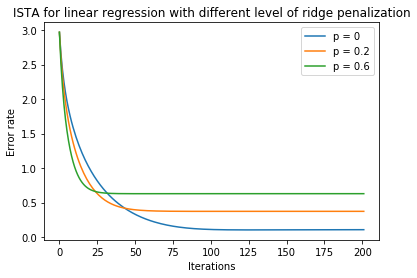

In [22]:
#Impact of the penalization for ISTA for linear regression

A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

x = randn(50)
I0 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =200)
I2 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.2, n_iter =200)
I6 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.6, n_iter =200)

x = np.arange(len(I0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, I0[2], label = 'p = 0')
plt.plot(x, I2[2], label = 'p = 0.2')
plt.plot(x, I6[2], label = 'p = 0.6')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('ISTA for linear regression with different level of ridge penalization')

plt.legend()
plt.show()

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.60e+00 | 3.19e+00
      10 | 1.72e+00 | 2.58e+00
      20 | 1.23e+00 | 2.09e+00
      30 | 9.45e-01 | 1.70e+00
      40 | 7.75e-01 | 1.38e+00
      50 | 6.71e-01 | 1.13e+00
      60 | 6.08e-01 | 9.38e-01
      70 | 5.70e-01 | 7.90e-01
      80 | 5.48e-01 | 6.80e-01
      90 | 5.35e-01 | 6.00e-01
     100 | 5.28e-01 | 5.41e-01
     110 | 5.23e-01 | 4.98e-01
     120 | 5.20e-01 | 4.66e-01
     130 | 5.19e-01 | 4.44e-01
     140 | 5.18e-01 | 4.27e-01
     150 | 5.17e-01 | 4.14e-01
     160 | 5.17e-01 | 4.05e-01
     170 | 5.16e-01 | 3.98e-01
     180 | 5.16e-01 | 3.92e-01
     190 | 5.16e-01 | 3.88e-01
     200 | 5.16e-01 | 3.85e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 6.59e+00 | 2.96e+00
      10 | 1.27e+00 | 1.25e+00
      20 | 6.84e-01 | 8.62e-01
      30 | 6.40e-01 | 8.06e-01
      40 | 6.37e-01 | 7.95e-01
      50 | 6.36e-01 | 7.92e-01
      60 | 6.36e-01 | 7.91e-01
      70 | 6.36e-01 | 

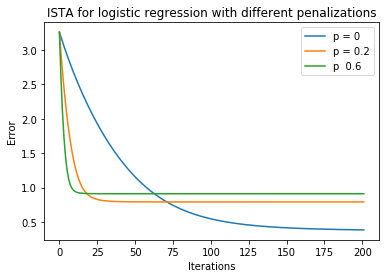

In [23]:
#Impact of the penalization for ISTA for logistic regression

A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)

x = randn(50)
I00 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0, n_iter =200)
I02 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.2, n_iter =200)
I06 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.6, n_iter =200)

x = np.arange(len(I00[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, I00[2], label = 'p = 0')
plt.plot(x, I02[2], label = 'p = 0.2')
plt.plot(x, I06[2], label = 'p  0.6')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('ISTA for logistic regression with different penalizations')

plt.legend()
plt.show()

As for FISTA algorithm, we can see that for ISTA, increasing penalization increases the convergence speed but also the error limit. 

#### Explanation

As we saw in the very first question, the penalization coefficient affects the "intensity" of the coefficients. If the penalization increases, the coefficients decreases proportionnaly. Therefore, the higher penalization is, the higher the error rate limit will be.

### Question 3 : comparison of the performance of the optimization algorithms for ridge and lasso penalizations

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.55e+01 | 2.58e+00
      10 | 1.06e+00 | 6.26e-01
      20 | 1.02e+00 | 6.07e-01
      30 | 1.02e+00 | 6.13e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.32e+01 | 2.59e+00
      10 | 1.47e+00 | 9.65e-01
      20 | 1.44e+00 | 9.90e-01
      30 | 1.44e+00 | 9.86e-01


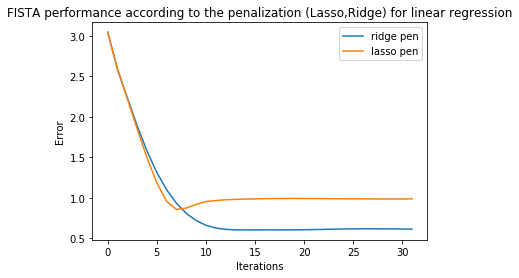

In [53]:
# FISTA for linear regression

A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
x = randn(50)
ridge = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.5, n_iter =30)
lasso = fista(x, loss_linreg, grad_linreg, lasso, prox_lasso, 1/L, s=0.5, n_iter =30)

x = np.arange(len(ridge[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, ridge[2], label = 'ridge pen')
plt.plot(x, lasso[2], label = 'lasso pen')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('FISTA performance according to the penalization (Lasso,Ridge) for linear regression')

plt.legend()
plt.show()

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.54e+01 | 3.11e+00
      10 | 1.34e+00 | 1.02e+00
      20 | 7.55e-01 | 9.45e-01
      30 | 6.80e-01 | 8.92e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.27e+01 | 3.14e+00
      10 | 3.19e+00 | 1.16e+00
      20 | 7.02e-01 | 1.00e+00
      30 | 6.93e-01 | 1.00e+00


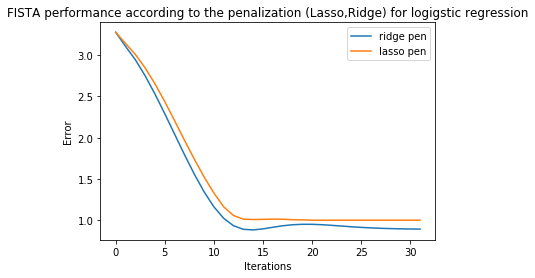

In [60]:
#FISTA for logistic regression

A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)

x = randn(50)
ridge2 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.5, n_iter =30)
lasso2 = fista(x, loss_logreg, grad_logreg, lasso, prox_lasso, 1/L, s=0.5, n_iter =30)


x = np.arange(len(ridge2[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, ridge2[2], label = 'ridge pen')
plt.plot(x, lasso2[2], label = 'lasso pen')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('FISTA performance according to the penalization (Lasso,Ridge) for logigstic regression')

plt.legend()
plt.show()


#There is a problem with the lasso penalization. For the code to run, you have to run the corresponding cell again...

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.80e+01 | 3.35e+00
      10 | 4.00e+00 | 1.27e+00
      20 | 1.54e+00 | 7.47e-01
      30 | 1.20e+00 | 6.14e-01
      40 | 1.14e+00 | 5.81e-01
      50 | 1.13e+00 | 5.72e-01
      60 | 1.13e+00 | 5.68e-01
      70 | 1.13e+00 | 5.67e-01
      80 | 1.13e+00 | 5.67e-01
      90 | 1.13e+00 | 5.67e-01
     100 | 1.13e+00 | 5.66e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 4.46e+01 | 3.40e+00
      10 | 7.17e+00 | 1.29e+00
      20 | 1.70e+00 | 9.53e-01
      30 | 1.65e+00 | 9.56e-01
      40 | 1.65e+00 | 9.58e-01
      50 | 1.65e+00 | 9.59e-01
      60 | 1.65e+00 | 9.59e-01
      70 | 1.65e+00 | 9.59e-01
      80 | 1.65e+00 | 9.59e-01
      90 | 1.65e+00 | 9.59e-01
     100 | 1.65e+00 | 9.59e-01


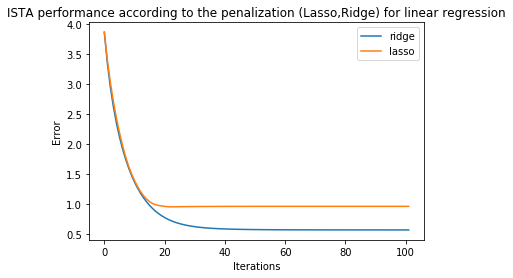

In [31]:
#ISTA for linear regression

A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)

x = randn(50)
ridge3 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.5, n_iter =100)
lasso3 = ista(x, loss_linreg, grad_linreg, lasso, prox_lasso, 1/L, s=0.5, n_iter =100)

x = np.arange(len(ridge3[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, ridge3[2], label = 'ridge')
plt.plot(x, lasso3[2], label = 'lasso')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('ISTA performance according to the penalization (Lasso,Ridge) for linear regression')

plt.legend()
plt.show()



Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.36e+01 | 2.88e+00
      10 | 4.82e+00 | 1.71e+00
      20 | 1.84e+00 | 1.14e+00
      30 | 9.59e-01 | 9.42e-01
      40 | 7.37e-01 | 8.95e-01
      50 | 6.84e-01 | 8.90e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.80e+01 | 2.79e+00
      10 | 4.82e+00 | 1.15e+00
      20 | 6.93e-01 | 1.00e+00
      30 | 6.93e-01 | 1.00e+00
      40 | 6.93e-01 | 1.00e+00
      50 | 6.93e-01 | 1.00e+00


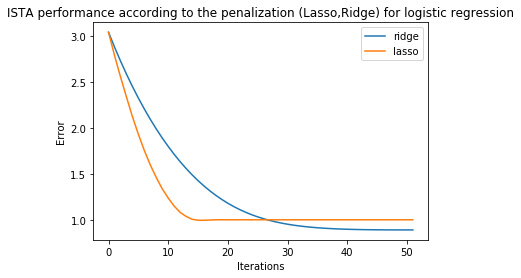

In [32]:
# ISTA for logistic regression

A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)

x = randn(50)
ridge4 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.5, n_iter =50)
lasso4 = ista(x, loss_logreg, grad_logreg, lasso, prox_lasso, 1/L, s=1, n_iter =50)


x = np.arange(len(ridge4[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, ridge4[2], label = 'ridge')
plt.plot(x, lasso4[2], label = 'lasso')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('ISTA performance according to the penalization (Lasso,Ridge) for logistic regression')

plt.legend()
plt.show()

In all cases, we can see that the error rate limit for the lasso penalization is always higher than the ridge one. We can explain this bacause in the lasso, a lot of coefficients are reduced to 0.